In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2 

### Read this First

#### Remember that `tab` is is useful for autocompletion.

#### Remember that `shift + tab` is useful for rapidly obtaining usage + documentation.

###**Camera Calibration with 3D Object**

**We learnt in class about calibration, and we'll explore a quick example of camera calibration using a 3D object.**

**First, load the image.**

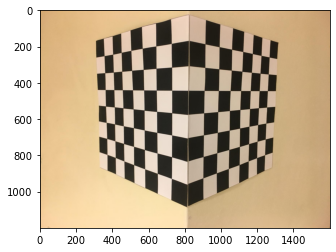

In [2]:
image = cv2.imread('3D_calibration_object.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
rows, cols, channels = image.shape
plt.figure()
plt.imshow(image)

**Calibration works by finding the relationship between pixel coordinates that you seen on the image, to real world coordinates in some world frame. In order to do this, we need to have the ability to find points in the image that we know the real world coordinates to.**

**Calibration objects are nice in that they have well defined features that can serve as these points, with measured coordinates for these features. Shown above is our calibration object. Each smaller square has dimensions 18mm x 18mm.**

**Convert the image to grayscale, and use OpenCV's cv2.cornerHarris to find the corners of the pattern in the calibration object. You might want to threshold the corner reponses for better results. Draw circles around those corners and display the resulting image.**

2839


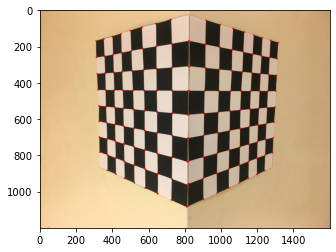

In [3]:
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(grayscale_image , 3 , 3 , 0.04 )
display_image = image.copy()
y,x = np.where(dst>0.01 * dst.max())
leng = len(y)
print(leng)
for i in range(leng):
    center_x = x[i]
    center_y = y[i]
    cv2.circle(display_image, (center_x, center_y), 3, (255,0,0),-1)
plt.imshow(display_image)
plt.show()

**How many corners are you able to find?**

2839

**Now that we have found the corners of the object, we need to know the pixel coordinates and the coordinates in the real world. Below are pixel coordinates corresponding to six of the corners of the calibration object. Draw circles around those corners and display them.**

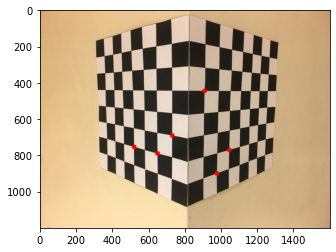

In [4]:
points = [(648, 789), (729, 690), (519, 753), (1044, 770), (976, 899), (908, 445)]
display_image = image.copy()
for point in points:
     cv2.circle(display_image, (point[0], point[1]), 13, (255,0,0),-1)
plt.imshow(display_image)
plt.show()

**Now we have the pixel coordinates, we need the corresponding real world coordinates for those corners. Below are the real world coordinates for the corners (in the same order).**

In [5]:
# Real world coordinates in (x, y, z)
location = [(0, 90, 36), (0, 72, 18), (0, 90, 72), (54, 90, 0), (36, 108, 0), (18, 36, 0)]

**In this case, where is the origin of the real world coordinate system? Which direction corresponds to the x axis? The y axis? The z axis?**

the upper corner(3D) of the checkboard in the picture is the origin
the edge that starts from the origin and goes toward the right side of the picture is the x axis
the edge that starts from the origin and goes toward the down side of the picture is the y axis
the edge that starts from the origin and goes toward the left side of the picture is the z axis

**Now that we have the real world coordinates and the pixel coordinates, as discussed in class, we can find $p$ the projection matrix. To do this, we can set up the equation $Ap=0$. Set up $A$ below. Refer to the slides in the lecture on how to construct $A$.**

In [6]:
data_num = 6
A = np.zeros((data_num*2, 12))
b = np.zeros((data_num*2, 1))
source = np.array(location.copy())
target = np.array(points.copy())
for i in range(data_num):
    A[i*2 , 0:3] = source[i ][ 0:3]
    A[i*2 , 3] = 1.0
    A[i*2 , 8:11] = -1*target[i][0]*source[i][ 0:3]
    A[i*2 , 11] = -1*target[i][0]
    
    A[i*2+1 , 4:7] = source[i ][ 0:3]
    A[i*2+1 , 7] = 1.0
    A[i*2+1 , 8:11] = -1*target[i][1]*source[i][ 0:3]
    A[i*2+1 , 11] = -1*target[i][1]
#A

**A trivial solution is when the projection matrix is all zeros, but that obviously isn't useful for us. Additionally, since our input data may be noisy, there may not be a perfect $p$ that exactly satisfies $Ap=0$. Hence we want to find the least squares solution.**

**As shown in the appendix in the lecture slides, we see that the eigenvector $p$ with the smallest eigenvalue $\lambda$ of matrix $A^TA$ is the solution to our problem.**

**Using np.linalg.svd, find the eigenvectors corresponding to $A^TA$. Extract the eigenvector corresponding to the smallest eigenvalue, and reshape it into a 3x4 matrix, which is the form of the projection matrix $p$. Print the result.**

In [7]:
U, s, V = np.linalg.svd(A)
#U, s, V = np.linalg.svd(A.T @ A)
p = V[ -1, :]
p = p.reshape(3,4)
print(p)
check = np.ones((6,4),dtype = np.float)
check[0:6 , 0:3] = source[0:6 , 0:3]

[[ 1.04123387e-02  3.23368750e-04 -2.48217735e-03  9.78761374e-01]
 [ 2.39546926e-03  9.15488258e-03  2.43527911e-03  2.04486177e-01]
 [ 5.02915352e-06  4.91913718e-07  5.07716104e-06  1.18836059e-03]]


**We often want to normalize our answer so that it has better properties when doing further processing. One way to do so is to normalize the projection matrix $p$ by ensuring that $p(2, 0:3)$ has unit norm. Normalize $p$ such that this is true below.**

In [8]:
length = np.sqrt( p[2,0:3] @ np.transpose(p[2 , 0:3]) )
p = p / length
print(p)
length = np.sqrt( p[2,0:3] @ np.transpose(p[2 , 0:3]) )
print(length)

for i in range(data_num):
    #print(source[i])
    tmp = np.array([source[i,0] , source[i,1] , source[i,2] , 1])
    tmp = tmp.T
    mapped = p @ tmp
    mapped /= mapped[2]
    #print(mapped)
    #print(target[i])

[[ 1.45358059e+03  4.51428401e+01 -3.46516277e+02  1.36636791e+05]
 [ 3.34411676e+02  1.27803754e+03  3.39969201e+02  2.85466261e+04]
 [ 7.02078582e-01  6.86720110e-02  7.08780515e-01  1.65897206e+02]]
0.9999999999999999


**Now that we have the projection matrix $p$, we can recover the extrinsic rotation $R$ and the intrinsic matrix $K$ via QR Decomposition. Using numpy's np.linalg.qr, do so below, and print out the results for $K$ and $R$.**

In [9]:
####
# I think it should be RQ factorization rather than QR
####
from scipy import linalg
K,R =  linalg.rq(p[: , 0:3])
K = K / K[2,2]
print('intrinsic K')
print(K)
print('extrinsic R')
print(R)
print("error")
print(K @ R - p[: , 0:3])

intrinsic K
[[-1.27655258e+03 -1.00157135e+01  7.78023866e+02]
 [-0.00000000e+00  1.24227378e+03  5.63512229e+02]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]
extrinsic R
[[ 0.71039231  0.00133675 -0.70380465]
 [ 0.04927915 -0.9976384   0.04784556]
 [-0.70207858 -0.06867201 -0.70878052]]
error
[[-2.90716119e+03 -9.02856802e+01  6.93032554e+02]
 [-6.68823353e+02 -2.55607508e+03 -6.79938403e+02]
 [-1.40415716e+00 -1.37344022e-01 -1.41756103e+00]]


**Using $K$ we can then recover the extrinsic translation $t$. Do so below, and print the results.**

In [13]:
t = p[0:3 , 3]
t = t.reshape(3,1)
t = np.linalg.inv(K) @ t
print(t)

[[ -5.5158286 ]
 [-52.27388609]
 [165.89720558]]


**Now, try changing the real world coordinate system and redefine the real world coordinates to those corners with your new coordinate system frame, and repeat the camera calibration. What happens to your parameters?**

the intrinsic matrix doesn't change（almost， given the few data points）, the extrinsic matrix changes （times the transformation of the new system） 

**There's a lot more you can explore too. For example, you can scale the $x$ coordinate of each of the corners, and see the effect that this has on the parameters. You can zoom in/out by scaling all (x, y, z) coordinates as well, and observe the effects.**

###**Camera Calibration with 2D Objects**

**Since you'll be doing this in your homework, I won't be covering this in the notebook anymore. Good luck!**